In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

In [2]:
def convert_position_to_numeric(pos):
    letter_part = pos[0]
    number_part = pos[1:]

    column = ord(letter_part.upper()) - ord('A') + 1
    row = int(number_part)

    return column, row

In [3]:
df = pd.read_csv("iBeacon_RSSI_Labeled.csv")
df[['column', 'row']] = df['location'].apply(lambda x: pd.Series(convert_position_to_numeric(x)))
df.drop('location', axis=1, inplace=True)

In [4]:
beacon_positions_raw = {
    'beacon1': "F09",
    'beacon2': "J04",
    'beacon3': "N04",
    'beacon4': "S05",
    'beacon5': "J07",
    'beacon6': "N07",
    'beacon7': "S07",
    'beacon8': "J10",
    'beacon9': "D09",
    'beacon10': "J15",
    'beacon11': "N15",
    'beacon12': "R15",
    'beacon13': "W13"
}

beacon_positions_numeric = {beacon: convert_position_to_numeric(pos) for beacon, pos in beacon_positions_raw.items()}
beacon_df = pd.DataFrame.from_dict(beacon_positions_numeric, orient='index', columns=['column', 'row'])

In [5]:
class KalmanFilter:
    def __init__(self, process_variance=1e-5, measurement_variance=0.1**2):
        self.process_variance = process_variance  
        self.measurement_variance = measurement_variance  
        self.estimated_measurement = 0.0 
        self.error_covariance = 1.0  

    def update(self, measurement):
        kalman_gain = self.error_covariance / (self.error_covariance + self.measurement_variance)
        self.estimated_measurement += kalman_gain * (measurement - self.estimated_measurement)
        self.error_covariance = (1 - kalman_gain) * self.error_covariance
        return self.estimated_measurement

In [6]:
beacons = [col for col in df.columns if col.startswith('b')]
kalman_filters = {beacon: KalmanFilter() for beacon in beacons}

# Apply Kalman filter smoothing to each RSSI value
for beacon in beacons:
    df[beacon] = df[beacon].apply(lambda rssi: kalman_filters[beacon].update(rssi) if not np.isnan(rssi) else rssi)

In [7]:
# A custom scoring function to calculate accuracy within 1 grid unit
def accuracy_within_radius(y_true, y_pred, radius=1):
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0]) ** 2 + (y_true[:, 1] - y_pred[:, 1]) ** 2)
    within_radius = distances <= radius
    accuracy = np.mean(within_radius) * 100  # Percentage of predictions within the radius
    return accuracy

# Custom scorer for accuracy within 1 grid unit
accuracy_scorer = make_scorer(accuracy_within_radius, greater_is_better=True, radius=1)

In [8]:
# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(mean_squared_error)
X = df[beacons]
y = df[['column', 'row']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
degrees = [1,2,3,4]
mean_mse_scores = []

for degree in degrees:
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
    ])
    
    mse_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    mean_mse = np.mean(mse_scores)
    mean_mse_scores.append(mean_mse)
    print(f"Degree: {degree}, Mean MSE: {mean_mse:.2f}")

# Select the best polynomial degree
best_degree_gbr = degrees[np.argmin(mean_mse_scores)]
print(f"Best polynomial degree based on cross-validation with GBR: {best_degree_gbr}")

Degree: 1, Mean MSE: 1.43
Degree: 2, Mean MSE: 1.46
Degree: 3, Mean MSE: 1.38


In [ ]:
pipeline_gbr = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree_gbr)),  
    ('gbr', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
])

param_grid_gbr = {
    'gbr__estimator__n_estimators': [200, 300, 400],
    'gbr__estimator__learning_rate': [0.05, 0.1],
    'gbr__estimator__max_depth': [3, 5, 7]
}

grid_search_gbr = GridSearchCV(estimator=pipeline_gbr, param_grid=param_grid_gbr, cv=cv, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)

best_params_gbr = grid_search_gbr.best_params_
print(f"Best parameters for GBR found: {best_params_gbr}")

best_n_estimators = best_params_gbr['gbr__estimator__n_estimators']
best_learning_rate = best_params_gbr['gbr__estimator__learning_rate']
best_max_depth = best_params_gbr['gbr__estimator__max_depth']

In [ ]:
pipeline_gbr_final = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree_gbr)),  
    ('gbr', MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=best_n_estimators,
        learning_rate=best_learning_rate,
        max_depth=best_max_depth,
        random_state=42
    )))
])

pipeline_gbr_final.fit(X_train, y_train)

# Predict using the final model on the test data
y_pred_gbr_final = pipeline_gbr_final.predict(X_test)

# Evaluate the final model
mse_gbr_final = mean_squared_error(y_test, y_pred_gbr_final)
print(f'Final Gradient Boosting Regressor - MSE on Test Set: {mse_gbr_final:.2f}')

# Optionally, calculate accuracy within 1 unit
accuracy_within_1m_gbr = accuracy_within_radius(y_test.to_numpy(), y_pred_gbr_final, radius=1)
print(f'Test Set Accuracy within 1 unit square (GBR): {accuracy_within_1m_gbr:.2f}%')


Final Gradient Boosting Regressor - MSE on Test Set: 0.98
Test Set Accuracy within 1 unit square (GBR): 86.62%


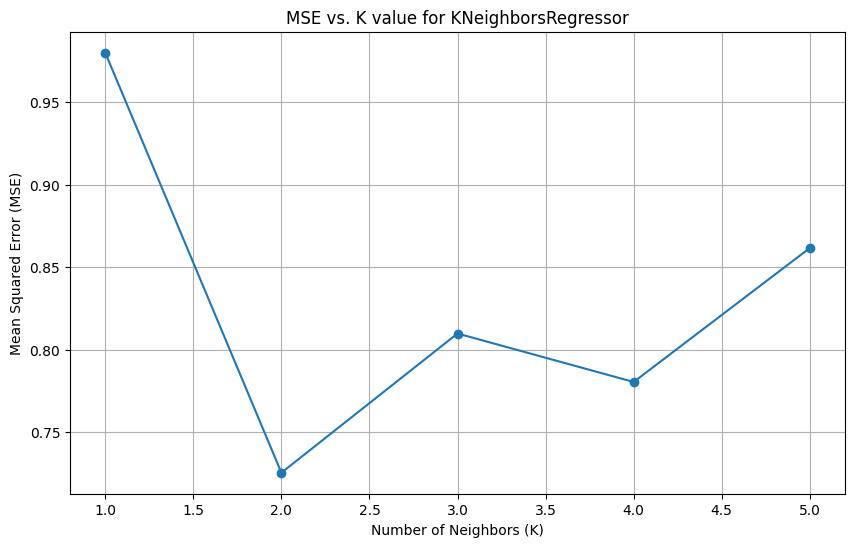

Best K value: 2 with MSE: 0.73
KNN MSE on Test Set: 1.03
Test Set Accuracy within 1 unit square (KNN): 91.55%


In [ ]:
k_values = [i for i in range(1, 6)]  # Range from 1 to 5
mse_scores = []

for k in k_values:
    knn = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k, weights='distance'))
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-np.mean(scores))  # Convert negative MSE to positive MSE

# Plotting k values vs MSE
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_scores, marker='o', linestyle='-')
plt.title('MSE vs. K value for KNeighborsRegressor')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.show()

# Find the best k value based on the lowest MSE
best_k = k_values[np.argmin(mse_scores)]
print(f"Best K value: {best_k} with MSE: {min(mse_scores):.2f}")

multi_knn = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=best_k, weights='distance'))
multi_knn.fit(X_train, y_train)

y_pred_knn_multi = multi_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn_multi)
print(f'KNN MSE on Test Set: {mse_knn:.2f}')

accuracy_within_1m_knn = accuracy_within_radius(y_test.to_numpy(), y_pred_knn_multi, radius=1)  
print(f'Test Set Accuracy within 1 unit square (KNN): {accuracy_within_1m_knn:.2f}%')

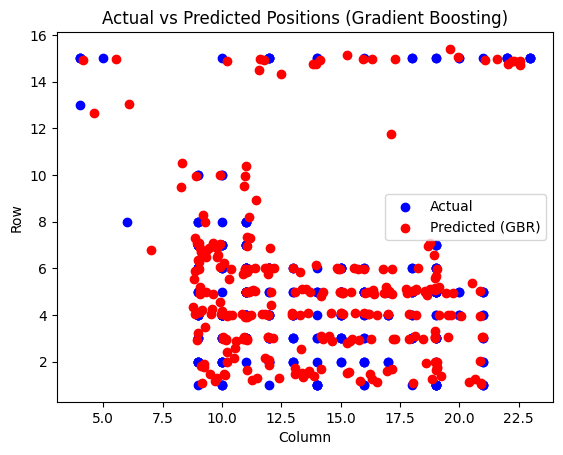

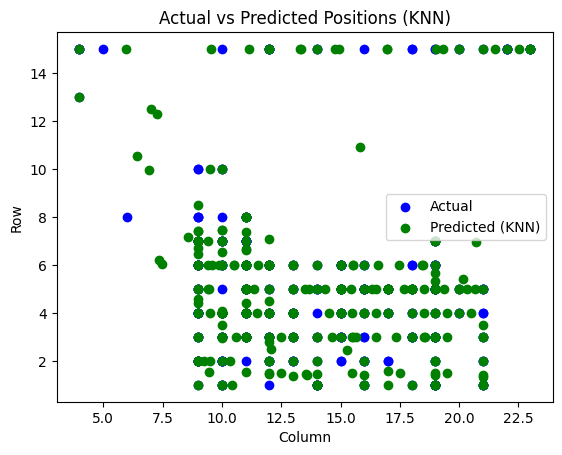

In [ ]:
# Visualize predictions vs. actuals for GBR
plt.scatter(y_test['column'], y_test['row'], color='blue', label='Actual')
plt.scatter(y_pred_gbr_final[:, 0], y_pred_gbr_final[:, 1], color='red', marker='o', label='Predicted (GBR)')
plt.title('Actual vs Predicted Positions (Gradient Boosting)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.legend()
plt.show()

# Visualize predictions vs. actuals for KNN
plt.scatter(y_test['column'], y_test['row'], color='blue', label='Actual')
plt.scatter(y_pred_knn_multi[:, 0], y_pred_knn_multi[:, 1], color='green', marker='o', label='Predicted (KNN)')
plt.title('Actual vs Predicted Positions (KNN)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.legend()
plt.show()